## 파이썬으로 만드는 투자 전략과 주요 지표

### 3.1. 바이앤홀드 (Buy and Hold)

바이앤홀드 전략은 주식을 매수한 후 장기 보유하는 투자 전략.<br>
주가는 예측이 불가하지만 경제가 성장함에 따라 장기적으로 우상향한다는 투자 철학의 관점에서 보면 합리적인 투자 방법.

In [1]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np

df = fdr.DataReader('AMZN', start='1997-05-15')


In [2]:
df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1997-05-15,1.96,2.44,2.50,1.93,72160000.0,-0.9962
1997-05-16,1.73,1.97,1.98,1.71,14700000.0,-0.1173
1997-05-19,1.71,1.76,1.77,1.62,6110000.0,-0.0116
1997-05-20,1.64,1.73,1.75,1.64,5470000.0,-0.0409
1997-05-21,1.43,1.64,1.65,1.37,18850000.0,-0.1280


In [3]:
# 결측치가 있는지 확인
df[df.isin([np.nan, np.inf, -np.inf]).any(1)]

,Close,Open,High,Low,Volume,Change
Date,,,,,,


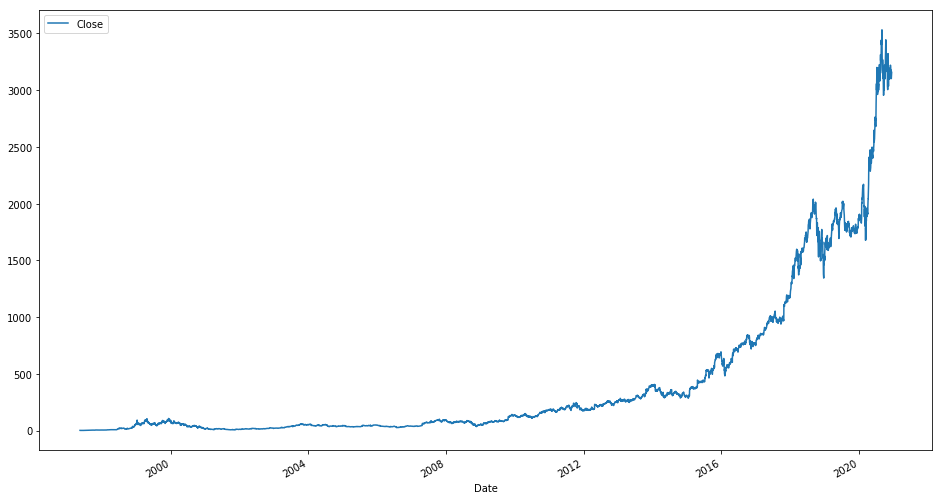

In [4]:
# 종가를 활용해서 바이앤홀드 전략을 테스트
price_df = df.loc[:, ['Close']].copy()
price_df.plot(figsize=(16, 9))

In [5]:
# 일별 수익률 계산
price_df['daily_rtn'] = price_df['Close'].pct_change()
price_df.head()

,Close,daily_rtn
Date,,
1997-05-15,1.96,NaN
1997-05-16,1.73,-0.117347
1997-05-19,1.71,-0.011561
1997-05-20,1.64,-0.040936
1997-05-21,1.43,-0.128049


In [6]:
# 누적 곱을 계산하여 매수 시점 대비 매도 시점의 종가 수익률 계산
price_df['st_rtn'] = (1+price_df['daily_rtn']).cumprod()
price_df.tail(10)

,Close,daily_rtn,st_rtn
Date,,,
2020-12-01,3220.08,0.016427,1642.897959
2020-12-02,3203.53,-0.005140,1634.454082
2020-12-03,3186.73,-0.005244,1625.882653
2020-12-04,3162.58,-0.007578,1613.561224
2020-12-07,3158.00,-0.001448,1611.224490
2020-12-08,3177.29,0.006108,1621.066327
2020-12-09,3104.20,-0.023004,1583.775510
2020-12-10,3101.49,-0.000873,1582.392857
2020-12-11,3116.42,0.004814,1590.010204


누적 수익 :  17.136955813701125


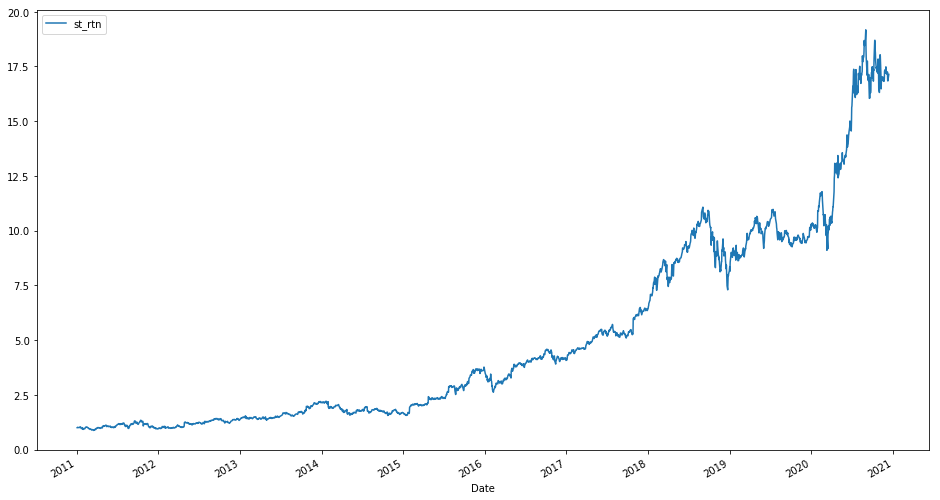

In [7]:
# 시점을 달리 설정하여 수익률 계산
base_date = '2011-01-03'
tmp_df = price_df.loc[base_date:, ['st_rtn']] / price_df.loc[base_date, ['st_rtn']] # base_date를 기준으로 나누어 줘서 매수 시점을 1로 변경
last_date = tmp_df.index[-1]
print('누적 수익 : ',tmp_df.loc[last_date,'st_rtn'])
tmp_df.plot(figsize=(16, 9))

2011년 1월 3일을 기준으로 현재까지의 누적수익률을 계산해보면 고점으로 20배 가까이 수익률을 올린 뒤 현재 약 17배 정도의 수익률을 얻은 것을 확인할 수 있다.

### 3.2. 투자 성과 분석 지표

+ 연평균 복리 수익률(compound annual growth rate, CAGR)
+ 최대 낙폭(maximum draw down, MDD)
+ 변동성 (Volatility, Vol)
+ 샤프 지수 (Sharpe ratio)

#### 3.2.1 연평균 복리 수익률 (CAGR)

수익률 성과를 분석할 때는 산술평균 수익률보다 복리 성질을 반영한 기하평균 수익률을 더 선호한다.


$$
CAGR(t_0, t_n) = \left ( {V(t_n) \over V(t_0)} \right) ^{1 \over t_n-t_0}- 1
$$


In [9]:
CAGR = price_df.loc['2019-06-24', 'st_rtn'] ** (252./len(price_df.index)) - 1
CAGR

0.3393629624690535

#### 3.2.2 최대 낙폭 (MDD)

최대 낙폭은 최대 낙폭 지수로, 투자 기간에 고점부터 저점까지 떨어진 낙폭 중 최댓값을 의미

$$
\text{최대 낙폭} = {\text{Trough  Value} - \text{Peak Value} \over \text{Peak Value}}
$$

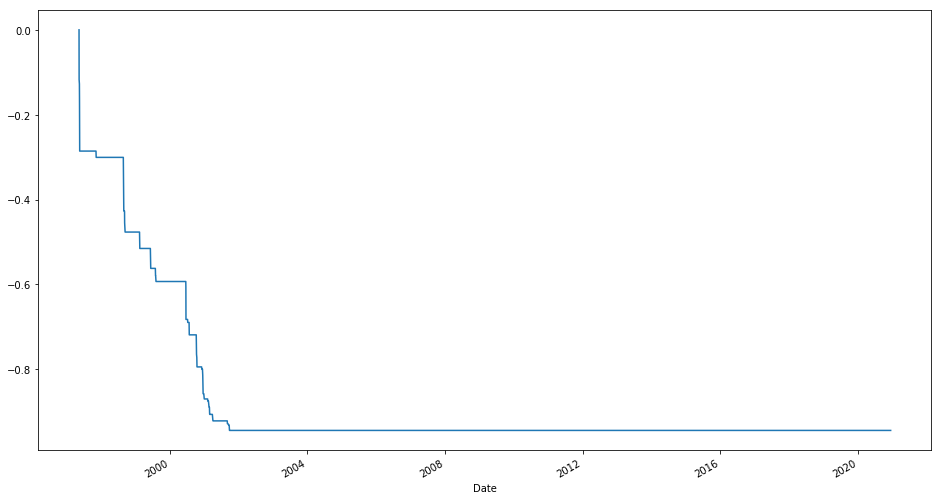

In [17]:
historical_max = price_df['Close'].cummax()
#cummax는 누적 최댓값을 반환
daily_drawdown = price_df['Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
#cummin은 누적 최솟값을 반환

historical_dd.plot(figsize=(16, 9))

#### 3.2.3 변동성 (Vol)

수익률의 표준 편차를 변동성으로 계산
$$
\sigma_p = \sigma_일 \sqrt{P}
$$

In [19]:
VOL = np.std(price_df['daily_rtn'])*np.sqrt(252.)
VOL

0.5874469807550086

#### 3.2.4 샤프 지수

샤프 지수는 위험 대비 수익성 지표로 자산 수익률에서 무위험 자산 (혹은 기준 지표 자산 수익률)을 차감한 Real 수익률을 자산 수익률의 변동성으로 계산한 것이다.


$$
S_a = {E[R_a - R_b] \over \sigma_a}
$$

In [21]:
Sharpe = np.mean(price_df['daily_rtn']) / np.std(price_df['daily_rtn']) * np.sqrt(252.)
Sharpe

0.8219391043656058

In [23]:
## 모든 성과 지표 적용
CAGR = price_df.loc['2019-06-24', 'st_rtn'] ** (252/len(price_df.index)) - 1
Sharpe = np.mean(price_df['daily_rtn']) / np.std(price_df['daily_rtn']) * np.sqrt(252.)
VOL = np.std(price_df['daily_rtn'])*np.sqrt(252.)
MDD = historical_dd.min()

print('CAGR : ', round(CAGR*100, 2), '%')
print('Sharpe : ', round(Sharpe, 2))
print('VOL : ', round(VOL*100, 2), '%')
print('MDD : ', round(-1*MDD*100, 2), '%')

CAGR :  33.94 %
Sharpe :  0.82
VOL :  58.74 %
MDD :  94.4 %
